In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [3]:
class model:
    C_0=0.1
    V_0=1.8
    tau_c=15
    tau_v=30
    alpha=0.05
    beta_0=0.05
    beta_s=0.005 #er refilling slope
    tau_er=10

    def __init__(self,params,T,spike_train):
        self.__dict__.update(params)
        self.T=T
        self.spike_train=spike_train
    
    def sim(self,seed):
        T,C_0,V_0,tau_c,tau_v,alpha,beta_0,beta_s,tau_er=self.T,self.C_0,self.V_0,self.tau_c,self.tau_v,self.alpha,self.beta_0,self.beta_s,self.tau_er
        random.seed(seed)

        self.release=np.zeros(spike_train.shape,dtype=np.bool)
        release=self.release

        C=np.zeros(T.shape)
        V=np.zeros(T.shape)
        beta=np.zeros(T.shape)
        P_s=np.zeros(T.shape)

        i=0
        for j,t in enumerate(T):
            #er Ca2+ depletion. beta is er contribution factor.
            beta[j]=max(0,beta_0-beta_s*sum(np.exp(-(t-spike_train[:i])/tau_er)))

            #facilitation with extracellular 'alpha' and intracellular 'beta' contributions
            C[j]=(alpha+beta[j])*(C_0+sum(np.exp(-(t-spike_train[:i])/tau_c)))

            #depression due to resource (vesicle) depletion 
            V[j]=max(0,V_0-sum(release[:i]*np.exp(-(t-spike_train[:i])/tau_v)))

            #vesicle release probability
            P_s[j]=1-np.exp(-C[j]*V[j])

            if i<len(spike_train):
                if t>=spike_train[i]:
                    u=random.uniform(0,1)
                    if u < P_s[j]:
                        release[i]=1
                    i+=1
        return np.stack([C,V,beta,P_s]),release

In [21]:
def func(params):
    
    T=np.linspace(0,2,1001)
    spike_train=np.array([0.0022, 0.0522, 0.1022, 0.1522, 0.2023, 0.2522, 0.3021, 0.3522,
           0.4022, 0.4522, 0.5022, 0.5523, 0.6022, 0.6522, 0.7023, 0.7522,
           0.8022, 0.8522, 0.9022, 0.9522])
    
    
    N=100
    M=[model(params,T,spike_train) for i in range(N)]
    
    def SIM(i):
        return M[i].sim(i)
    
    P=Pool(8)
    datas,releases=zip(*P.map(SIM,list(range(N))))
    data=np.average(np.array(datas),axis=0)
    release=np.average(np.array(releases),axis=0)
    #spike_train=np.average(np.array(spike_trains),axis=0)
    C=data[0,:]
    V=data[1,:]
    beta=data[2,:]
    P_s=data[3,:]

In [22]:
func(params)

AttributeError: Can't pickle local object 'func.<locals>.SIM'

In [15]:
params={
    'C_0':0.6,
    'V_0':1.8,
    'tau_c':0.1,
    'tau_v':3,
    'alpha':0.2,
    'beta_0':0.1,
    'beta_s':0.005, #er refilling slope
    'tau_er':10}

T=np.linspace(0,2,1001)
spike_train=np.array([0.0022, 0.0522, 0.1022, 0.1522, 0.2023, 0.2522, 0.3021, 0.3522,
       0.4022, 0.4522, 0.5022, 0.5523, 0.6022, 0.6522, 0.7023, 0.7522,
       0.8022, 0.8522, 0.9022, 0.9522])

M=model(params,T,spike_train)
M.sim(1)

(array([[0.18      , 0.18      , 0.18      , ..., 0.12844898, 0.12845898,
         0.12846898],
        [1.8       , 1.8       , 1.8       , ..., 0.10571625, 0.10684539,
         0.10797379],
        [0.1       , 0.1       , 0.1       , ..., 0.01405507, 0.01407225,
         0.01408944],
        [0.27674976, 0.27674976, 0.27674976, ..., 0.01348736, 0.01363149,
         0.01377552]]),
 array([ True, False, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False]))

In [203]:
C=data[0,:]
V=data[1,:]
beta=data[2,:]
P_s=data[3,:]
data.shape

(4, 1001)

Text(0.5, 1.0, 'Releases')

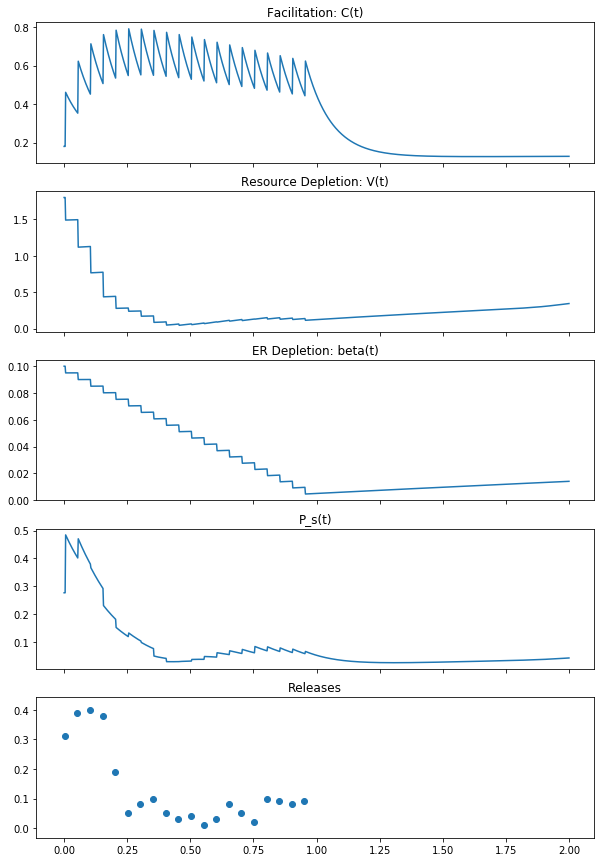

In [204]:
fig, ax = plt.subplots(nrows=5,ncols=1,sharex=True,figsize=(10,15))

ax[0].plot(T,C)
ax[0].set_title("Facilitation: C(t)")

ax[1].plot(T,V)
ax[1].set_title("Resource Depletion: V(t)")

ax[2].plot(T,beta)
ax[2].set_title("ER Depletion: beta(t)")

ax[3].plot(T,P_s)
ax[3].set_title("P_s(t)")

ax[4].scatter(spike_train,release)
ax[4].set_title("Releases")

## Loading mcell results

In [209]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
peaks={}

fnames=["R150control20hz","R150ER2x20hz","R150ER3x20hz","R300ER2x20hz","R300ER3x20hz"] #,"R150ER2x20hz" "R150ER3x20hz"
for sim_type in fnames:
    loc=res_loc+sim_type+"/result"
    print(loc)
    data[sim_type]=np.loadtxt(loc)
    peaks[sim_type]=np.loadtxt(res_loc+sim_type+"/caStat.dat").T[1]

/home/kabir/Project/tripartiteSynapse/results/freq/R150control20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER3x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/result


In [217]:
data["R150control20hz"].T[1]


array([0.0744, 0.2672, 0.3853, 0.4909, 0.6266, 0.6735, 0.6393, 0.6996,
       0.688 , 0.6778, 0.6242, 0.5712, 0.4756, 0.4314, 0.3758, 0.312 ,
       0.2895, 0.2487, 0.2514, 0.263 ])

In [215]:
peaks["R300ER3x20hz"]

array([0.0022, 0.0523, 0.1022, 0.1522, 0.2023, 0.2522, 0.3022, 0.3523,
       0.4022, 0.4522, 0.5022, 0.5522, 0.6022, 0.6522, 0.7023, 0.7522,
       0.8022, 0.8522, 0.9022, 0.9522])

In [95]:
C_0=0.6
V_0=1.8
tau_c=15
tau_v=30
alpha=0.1
beta_0=0.1
beta_s=0.005 #er refilling slope
tau_er=10

1-np.exp(-((alpha+beta_0)*C_0*V_0))

0.19426469812652036

In [46]:
#input spike times
spike_train=np.array([1,2,3,4,5,6,7,8,9,10])
release=np.zeros(10,dtype=np.bool)

In [4]:
for i,t in enumerate(spike_train):
    C=C_0+alpha*sum(np.exp((t-spike_train[:i])/tau_c))
    V=V_0-sum(np.exp(t-release[:i]/tau_v))
    P_s=1-np.exp(-C*V)
    if uniform(0,1) < P_s:
        release[i]=1